## Movie Genre Classification

Create a machine learning model that can predict the genre of a movie based on its plot summary or other textual information. You can use techniques like TF-IDF or word embeddings with classifiers such as Naive Bayes, Logistic Regression, or Support Vector Machines.

### Importing libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

### Load Dataset

In [6]:
train_path = "Genre Classification Dataset/train_data.txt"
train_data = pd.read_csv(train_path, sep = ':::', names = ['Title', 'Genre', 'Description'], engine = 'python')

In [7]:
train_data.head()

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [8]:
test_path = "Genre Classification Dataset/test_data.txt"
test_data = pd.read_csv(test_path, sep = ':::', names = ['Id', 'Title', 'Description'], engine = 'python')

In [9]:
test_data.head()

,Id,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


### Data Preprocessing

In [10]:
train_data.shape

(54214, 3)

In [11]:
test_data.shape

(54200, 3)

In [12]:
train_data.describe()

,Title,Genre,Description
count,54214,54214,54214
unique,54214,27,54086
top,Oscar et la dame rose (2009),drama,Grammy - music award of the American academy ...
freq,1,13613,12


In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [14]:
train_data.isnull().sum()

Title          0
Genre          0
Description    0
dtype: int64

### EDA and Data Visualization

Text(0, 0.5, 'Genre')

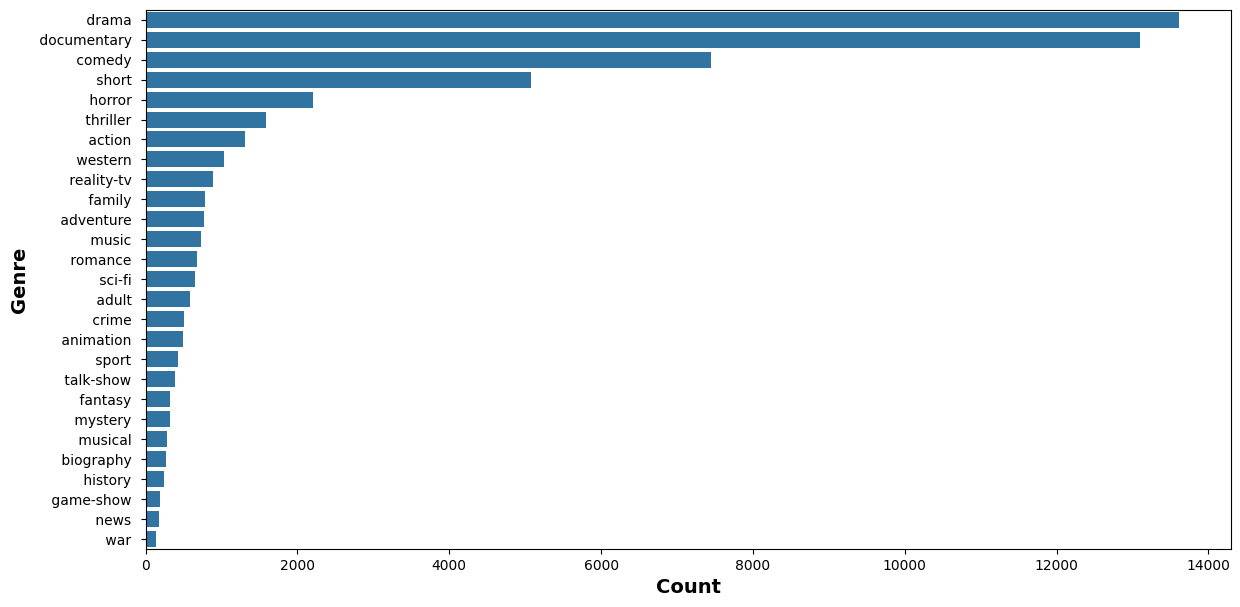

In [15]:
plt.figure(figsize = (14, 7))
sns.countplot(data = train_data, y = 'Genre', hue = None, order = train_data['Genre'].value_counts().index, legend = False)
plt.xlabel('Count', fontsize = 14, fontweight = 'bold')
plt.ylabel('Genre', fontsize = 14, fontweight = 'bold')

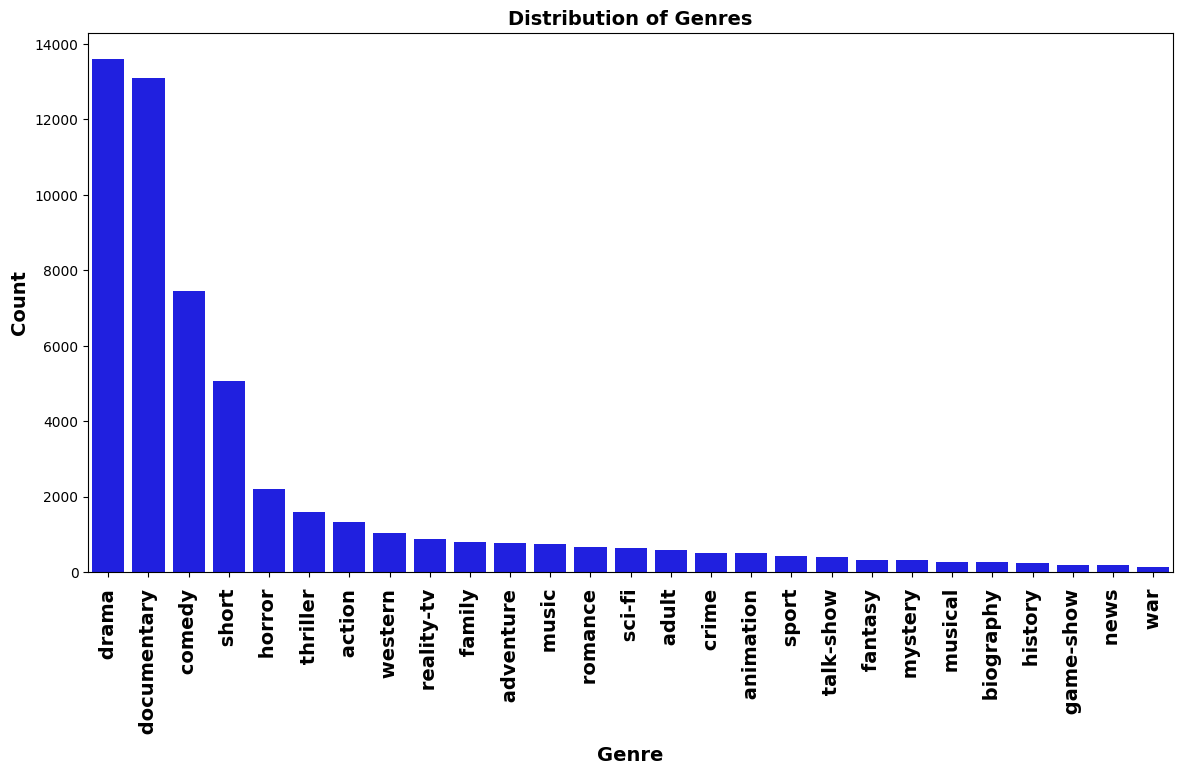

In [16]:
plt.figure(figsize = (14,7))
counts = train_data.Genre.value_counts()
sns.barplot(x = counts.index, y = counts, color = 'blue')
plt.title('Distribution of Genres', fontsize = 14, fontweight = 'bold')
plt.xlabel('Genre', fontsize = 14, fontweight = 'bold')
plt.ylabel('Count', fontsize = 14, fontweight = 'bold')
plt.xticks(rotation = 90, fontsize = 14, fontweight = 'bold');

In [17]:
train_data['length'] = train_data['Description'].apply(len)
train_data.head()

,Title,Genre,Description,length
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625


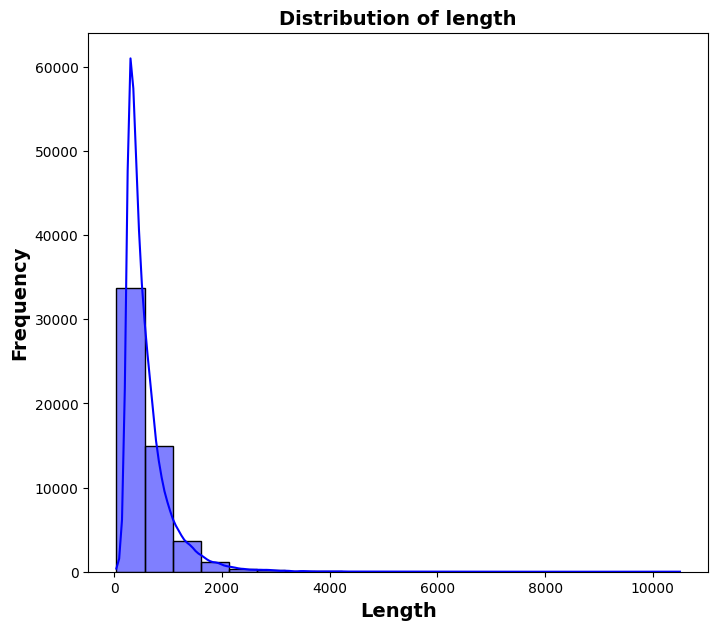

In [18]:
plt.figure(figsize = (8,7))
sns.histplot(data = train_data, x = 'length', bins = 20, kde = True, color = 'blue')
plt.xlabel('Length', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 14, fontweight = 'bold')
plt.title('Distribution of length', fontsize = 14, fontweight = 'bold')
plt.show()

### Data Cleaning and Preprocessing

In [19]:
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub('-', ' ', text.lower())
    text = re.sub(f'[{string.digits}]', ' ', text)
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'https\S+', '', text)
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text+' ')
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.tokenize.word_tokenize(text, language = 'english', preserve_line = True)
    stopwords = nltk.corpus.stopwords.words('english')
    text = " ".join([i for i in words if i not in stopwords and len(i)>2])
    text = re.sub("\s[\s]+", ' ', text).strip()
    return re.sub(f'[{re.escape(string.punctuation)}]', '', text)

input_text = "Certainly you get a dramatic boost from hello bye the the hi -iv iem-k q934*2yee !*3 2e38"
print(f'Original text : {input_text}')
print(f'Cleaned text : {clean_text(input_text)}')

Original text : Certainly you get a dramatic boost from hello bye the the hi -iv iem-k q934*2yee !*3 2e38
Cleaned text : certain get dram boost hello bye iem


In [20]:
train_data['Text_cleaning'] = train_data['Description'].apply(clean_text)
test_data['Text_cleaning'] = test_data['Description'].apply(clean_text)

In [21]:
train_data.head()

,Title,Genre,Description,length,Text_cleaning
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546,list convers doct parents year old osc learn n...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184,broth sist past incestu rel cur murd relations...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650,bus empty stud field trip muse nat history lit...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082,help unemploy fath mak end meet edi twin sist ...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625,films titl ref recov body ground zero also sta...


In [22]:
test_data.head()

,Id,Title,Description,Text_cleaning
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",bran lov lif car apartment job espec girlfrien...
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",spain march quico naughty child three belong w...
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...,year lif albin famy shepherd transylvania dire...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",fath died spok broth year sery cancer diego ta...
4,5,Er nu zhai (1955),Before he was known internationally as a mart...,known intern mart art superstar bruc lee appea...


In [23]:
train_data['len_clean_text'] = train_data['Text_cleaning'].apply(len)
train_data.head()

,Title,Genre,Description,length,Text_cleaning,len_clean_text
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546,list convers doct parents year old osc learn n...,324
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184,broth sist past incestu rel cur murd relations...,83
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650,bus empty stud field trip muse nat history lit...,325
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082,help unemploy fath mak end meet edi twin sist ...,616
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625,films titl ref recov body ground zero also sta...,282


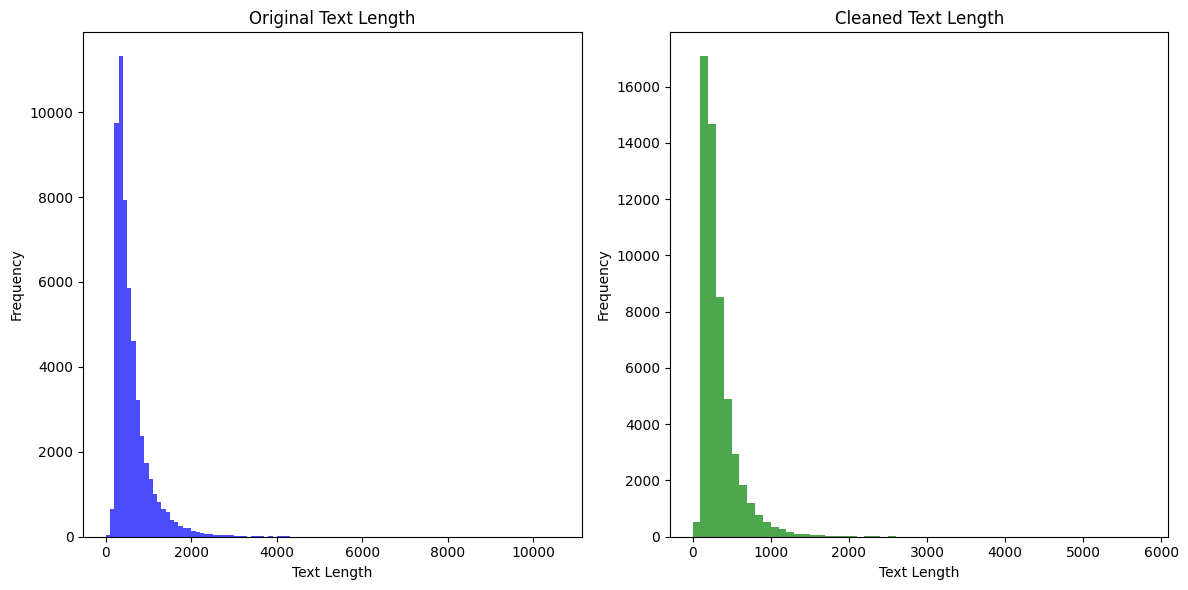

In [24]:
plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)
original_length = train_data['Description'].apply(len)
plt.hist(original_length, bins = range(0, max(original_length) + 100, 100), color = 'blue', alpha = 0.7)
plt.title('Original Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
cleaned_length = train_data['Text_cleaning'].apply(len)
plt.hist(cleaned_length, bins = range(0, max(cleaned_length) + 100, 100), color = 'green', alpha = 0.7)
plt.title('Cleaned Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [25]:
(train_data['len_clean_text'] > 2000).value_counts()

len_clean_text
False    54131
True        83
Name: count, dtype: int64

In [26]:
print('Dataframe size (before removal): ', len(train_data))
filt = train_data['len_clean_text'] > 2000
train_data.drop(train_data[filt].index, axis = 0, inplace = True)
print('Dataframe size (after removal): ', len(train_data))
print(f'Removed rows: {filt.sum()}')

Dataframe size (before removal):  54214
Dataframe size (after removal):  54131
Removed rows: 83


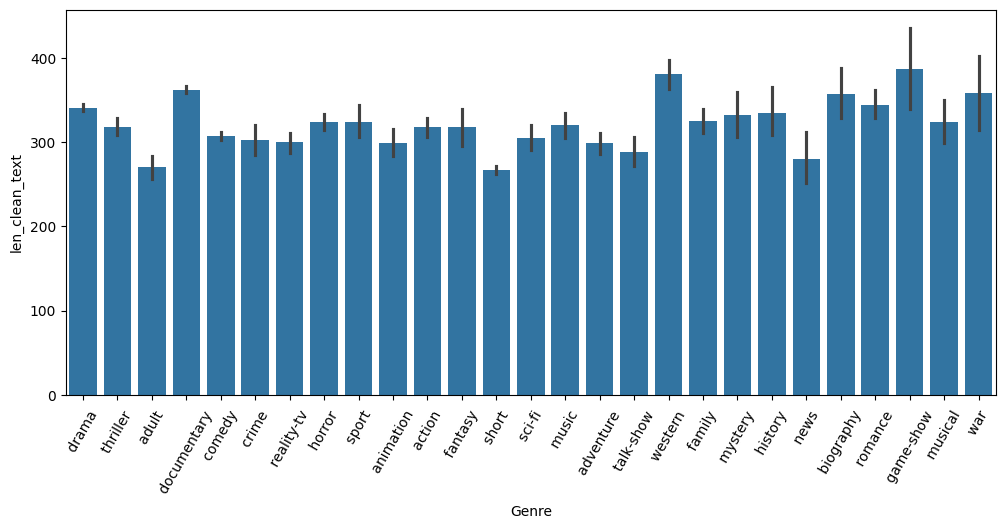

In [27]:
plt.figure(figsize = (12,5))
sns.barplot(x = 'Genre' ,y = 'len_clean_text' ,data = train_data) 
plt.xticks(rotation = 60)
plt.show()

C:\Users\acerKSG\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\acerKSG\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\acerKSG\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\acerKSG\AppData\Local\Programs\Python\P

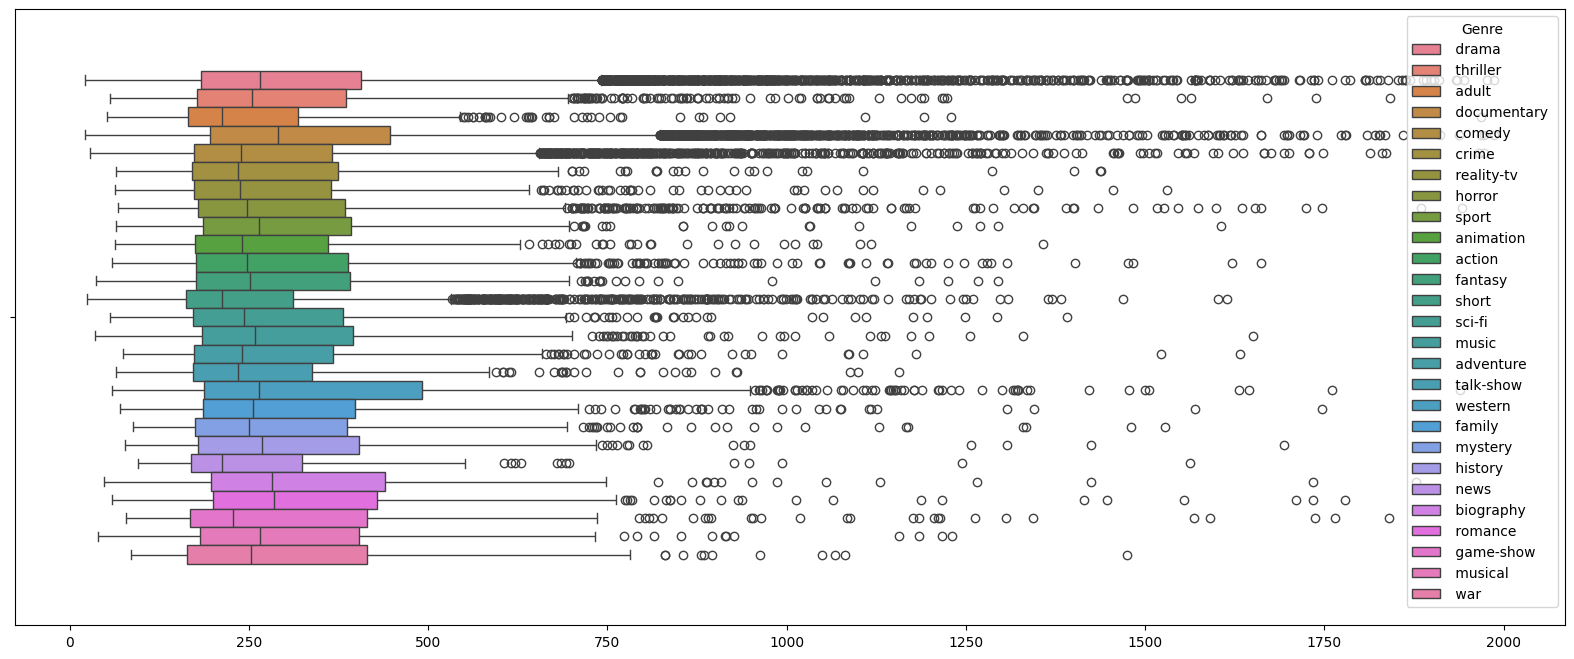

In [28]:
plt.figure(figsize = (20,8))
sns.boxplot(x = train_data['len_clean_text'].values,hue = 'Genre',data = train_data)
plt.show()

### Text Tokenization and Vectorization

In [29]:
num_words = 50000
max_len = 250
tokenizer = Tokenizer(num_words = num_words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower = True)
tokenizer.fit_on_texts(train_data['Text_cleaning'].values)

In [30]:
test_path = "Genre classification Dataset/test_data_solution.txt"
test_data_sol = pd.read_csv(test_path, sep = ':::', engine = 'python', names = ['ID', 'Title', 'Genre', 'Description'])
test_data_sol.head()

,ID,Title,Genre,Description
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a mart...


### Text Vectorizer (TF-IDF)

In [31]:
X = tokenizer.texts_to_sequences(train_data['Text_cleaning'].values)
X = pad_sequences(X, maxlen = max_len)
y = pd.get_dummies(train_data['Genre']).values

X_test = tokenizer.texts_to_sequences(test_data['Text_cleaning'].values)
X_test = pad_sequences(X, maxlen = max_len)
y_test = pd.get_dummies(test_data_sol['Genre']).values

In [32]:
tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(train_data['Text_cleaning'])
X_test = tfidf_vectorizer.transform(test_data['Text_cleaning'])

### Build LSTM Model

In [33]:
EMBEDDING_DIM = 100
model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout = 0.1, recurrent_dropout = 0.2))
model.add(Dense(27, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])  

C:\Users\acerKSG\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### Model Training

In [34]:
X = X_train
y = train_data['Genre']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

#### 1. Naive Bayes

In [35]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

MultinomialNB()

In [36]:
y_pred_nb = nb_classifier.predict(X_val)

In [38]:
acc = accuracy_score(y_val, y_pred_nb)
print("Accuracy (Naive Bayes): ", acc)

print("Classification report: \n", classification_report(y_val, y_pred_nb))

Accuracy (Naive Bayes):  0.43585480742587973


C:\Users\acerKSG\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\acerKSG\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification report: 
                precision    recall  f1-score   support

      action        0.00      0.00      0.00       254
       adult        0.00      0.00      0.00       105
   adventure        0.00      0.00      0.00       134
   animation        0.00      0.00      0.00       101
   biography        0.00      0.00      0.00        45
      comedy        0.72      0.02      0.04      1505
       crime        0.00      0.00      0.00       116
 documentary        0.51      0.89      0.65      2605
       drama        0.38      0.86      0.53      2732
      family        0.00      0.00      0.00       158
     fantasy        0.00      0.00      0.00        65
   game-show        0.00      0.00      0.00        48
     history        0.00      0.00      0.00        47
      horror        0.00      0.00      0.00       434
       music        0.00      0.00      0.00       145
     musical        0.00      0.00      0.00        57
     mystery        0.00      0.00     

C:\Users\acerKSG\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### 2. Logistic Regression

In [41]:
lr_classifier = LogisticRegression(max_iter = 200)
lr_classifier.fit(X_train, y_train)

LogisticRegression(max_iter=200)

In [42]:
y_pred_lr = lr_classifier.predict(X_val)

In [43]:
acc = accuracy_score(y_val, y_pred_lr)
print("Accuracy (Logistic Regression): ", acc)

print("Classification report: \n", classification_report(y_val, y_pred_lr))

Accuracy (Logistic Regression):  0.5700563406299067


C:\Users\acerKSG\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification report: 
                precision    recall  f1-score   support

      action        0.48      0.19      0.27       254
       adult        0.67      0.21      0.32       105
   adventure        0.65      0.13      0.21       134
   animation        0.57      0.04      0.07       101
   biography        0.00      0.00      0.00        45
      comedy        0.52      0.57      0.54      1505
       crime        0.00      0.00      0.00       116
 documentary        0.64      0.87      0.73      2605
       drama        0.52      0.78      0.63      2732
      family        0.57      0.05      0.09       158
     fantasy        0.00      0.00      0.00        65
   game-show        0.71      0.31      0.43        48
     history        0.00      0.00      0.00        47
      horror        0.73      0.55      0.63       434
       music        0.60      0.35      0.44       145
     musical        0.00      0.00      0.00        57
     mystery        0.00      0.00     

C:\Users\acerKSG\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\acerKSG\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Logistic Regression(57%) has better accuracy than Naive Bayes(43.58%)